# Chemicals analysis

## Importing librariries and modules

In [30]:
import os
import gc
import re
import requests
import time
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats import diagnostic
from scipy import stats

from src.drugbank_XML_drugparser import DrugParser
from src.drugbank_bindingdb_merger import DrugBank_BindingDB_Merger
from src.preprocessing import Preprocessing, ColumnClean

from src.data_paths import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## importing merged BDB and DB

In [64]:
merged_df = pd.read_pickle(MERGED)

In [65]:
merged_df.columns

Index(['ki', 'ph', 'temp', 'ic50', 'ec50', 'kd', 'kon', 'koff', 'doi',
       'target_name', 'pubchem_cid', 'chebi_id', 'chembl_id', 'drugbank_id',
       'kegg_id', 'zinc_id', 'smiles', 'inchi_key', 'bindingdb_id',
       'swissprot_target_chain_name', 'swissprot_target_chain_entry_name',
       'swissprot_protein_id', 'Unique_ID', 'chebi_id_BindingDB',
       'chembl_id_BindingDB', 'drugbank_id_BindingDB', 'smiles_BindingDB',
       'inchi_key_BindingDB', 'bindingdb_id_BindingDB', 'drugbank_id_DrugBank',
       'name_x', 'unii', 'toxicity', 'class_kingdom', 'class_superclass',
       'synonyms', 'categories', 'patent_approved', 'interaction',
       'chembl_id_DrugBank', 'smiles_DrugBank', 'inchi_key_DrugBank',
       'chebi_id_DrugBank', 'bindingdb_id_DrugBank', 'Matched_On', 'name_y',
       'general-function', 'specific-function', 'organism'],
      dtype='object')

## Importing cancerous proteins dataframe and filtering merged_df

In [66]:
# loads cancerous protein dataframe
protein_classes = pd.read_csv("data/clean/protein_class_COSMIC.tsv", sep='\t')
# test
#protein_classes[protein_classes.Gene=="CCND1"]
cancer_proteins = list(protein_classes["Gene"].values)

# joins all targeted proteins 
pattern_protein_names = '|'.join(rf"\b{re.escape(term)}\b" for term in cancer_proteins)

#test
#pattern_protein_names

# extract rows based on the columns that contain cancer_keywords 
filtered_df = merged_df[
    #merged_df['specific-function'].str.contains(pattern_protein_names, case=False, na=False) |
    #merged_df['swissprot_target_chain_name'].str.contains(pattern_protein_names, case=False, na=False) |
    #merged_df['swissprot_target_chain_entry_name'].str.contains(pattern_protein_names, case=False, na=False) |
    merged_df['name_y'].str.contains(pattern_protein_names, case=False, na=False)
]
filtered_df.reset_index(inplace=True)


print(filtered_df.shape)
filtered_df.head()

(20199, 50)


,index,ki,ph,temp,ic50,ec50,kd,kon,koff,doi,...,chembl_id_DrugBank,smiles_DrugBank,inchi_key_DrugBank,chebi_id_DrugBank,bindingdb_id_DrugBank,Matched_On,name_y,general-function,specific-function,organism
0,8960,<NA>,7.6,22.0,840.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm0201722,...,NaN,NaN,NaN,NaN,NaN,NaN,CCND1,Transcription factor binding,Regulatory component of the cyclin D1-CDK4 (DC...,Humans
1,8961,<NA>,7.6,22.0,490.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm0201722,...,NaN,NaN,NaN,NaN,NaN,NaN,CCND1,Transcription factor binding,Regulatory component of the cyclin D1-CDK4 (DC...,Humans
2,8962,<NA>,7.6,22.0,640.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm0201722,...,NaN,NaN,NaN,NaN,NaN,NaN,CCND1,Transcription factor binding,Regulatory component of the cyclin D1-CDK4 (DC...,Humans
3,8963,<NA>,7.6,22.0,1900.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm0201722,...,NaN,NaN,NaN,NaN,NaN,NaN,CCND1,Transcription factor binding,Regulatory component of the cyclin D1-CDK4 (DC...,Humans
4,8964,<NA>,7.6,22.0,2800.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm0201722,...,NaN,NaN,NaN,NaN,NaN,NaN,CCND1,Transcription factor binding,Regulatory component of the cyclin D1-CDK4 (DC...,Humans


In [67]:
## looking ofr mutant proteins

string_columns = filtered_df.select_dtypes(include=["object", "string"])
#print(string_columns)

for col in string_columns:
    print()
    print(col)
    print(filtered_df[col].str.contains("cancer", na=False, case=False).unique())
    print()


doi
<BooleanArray>
[False]
Length: 1, dtype: boolean


target_name
<BooleanArray>
[False]
Length: 1, dtype: boolean


chembl_id
<BooleanArray>
[False]
Length: 1, dtype: boolean


drugbank_id
<BooleanArray>
[False]
Length: 1, dtype: boolean


kegg_id
<BooleanArray>
[False]
Length: 1, dtype: boolean


zinc_id
<BooleanArray>
[False]
Length: 1, dtype: boolean


smiles
<BooleanArray>
[False]
Length: 1, dtype: boolean


inchi_key
<BooleanArray>
[False]
Length: 1, dtype: boolean


swissprot_target_chain_name
<BooleanArray>
[False]
Length: 1, dtype: boolean


swissprot_target_chain_entry_name
<BooleanArray>
[False]
Length: 1, dtype: boolean


swissprot_protein_id
[False]


chembl_id_BindingDB
[False]


drugbank_id_BindingDB
[False]


smiles_BindingDB
[False]


inchi_key_BindingDB
[False]


drugbank_id_DrugBank
[False]


name_x
[False]


unii
[False]


toxicity
[False  True]


class_kingdom
[False]


class_superclass
[False]


synonyms
[False  True]


categories
[False  True]


patent_approved

In [68]:
cancer_keywords= [
    # General Cancer Terms
    "Cancer", "Tumor", "Carcinoma", "Sarcoma", "Malignancy", "Neoplasm", 
    "Metastasis", "Oncogene", "Antineoplastic", "Chemotherapy", 
    "Radiotherapy", "Immunotherapy", "Targeted therapy", "Cytotoxic", "Cancerous", 
    "Oncogenesis", "Tumorigenesis"
    
    # Types of Cancer - Common Solid Tumors
    "Breast cancer", "Lung cancer", "Colorectal cancer", "Pancreatic cancer", 
    "Prostate cancer", "Melanoma", "Ovarian cancer", "Brain tumor", 
    "Liver cancer", "Gastric cancer", "Esophageal cancer", "Kidney cancer",
    
    # Types of Cancer - Hematological Malignancies
    "Leukemia", "Lymphoma", "Myeloma", "Hodgkin's lymphoma", 
    "Non-Hodgkin's lymphoma", "Chronic lymphocytic leukemia (CLL)", 
    "Acute myeloid leukemia (AML)",
    
    # Molecular Targets and Mechanisms - Proteins
    "Tyrosine kinase", "EGFR", "HER2", "VEGF", "PD-1", "PD-L1", 
    "CTLA-4", "BCL-2",
    
    # Molecular Targets and Mechanisms - Genes and Pathways
    "KRAS", "TP53", "BRCA1", "BRCA2", "MYC", "PI3K", "RAS/RAF/MEK/ERK pathway", 
    "JAK/STAT pathway", "Wnt signaling", "Hedgehog pathway",
    
    # Molecular Targets and Mechanisms - Drug Mechanisms
    "Apoptosis inducer", "Angiogenesis inhibitor", "DNA alkylation", 
    "DNA intercalation", "Topoisomerase inhibitor", "Microtubule stabilizer", 
    "Immune checkpoint inhibitor",
    
    # Specific Drug Classes
    "Alkylating agents", "Antimetabolites", "Anthracyclines", "Taxanes", 
    "Platinum compounds", "Monoclonal antibodies", "PARP inhibitors", 
    "CDK inhibitors", "HDAC inhibitors", "Proteasome inhibitors", 
    "mTOR inhibitors",
    
    # Treatment-Related Terms
    "Cytotoxicity", "Resistance", "Hormone therapy", "Anti-angiogenic", 
    "Cell cycle arrest", "Radiosensitizer", "Synergistic therapy",
    
    # Emerging Terms
    "Precision oncology", "Epigenetic modulation", 
    "Adoptive cell therapy", "CAR-T cell therapy", "Tumor microenvironment", 
    "Cancer stem cells"
]

In [69]:
# List of cancer-related proteins categorized by roles in treatment
cancer_proteins = {
    "Receptors": [
        "EGFR",  # Epidermal Growth Factor Receptor
        "HER2/ERBB2",  # Human Epidermal Growth Factor Receptor 2
        "PDGFR",  # Platelet-Derived Growth Factor Receptor
        "VEGFR",  # Vascular Endothelial Growth Factor Receptor
        "MET",  # Hepatocyte Growth Factor Receptor (c-Met)
    ],
    "Cell Cycle Regulators": [
        "CDK4",  # Cyclin-Dependent Kinase 4
        "CDK6",  # Cyclin-Dependent Kinase 6
        "Cyclin D1",  # Cell cycle progression protein
        "TP53",  # Tumor suppressor protein p53
        "RB1",  # Retinoblastoma protein
    ],
    "Signal Transduction Proteins": [
        "KRAS",  # Kirsten Rat Sarcoma Viral Oncogene Homolog
        "BRAF",  # B-Raf proto-oncogene
        "PI3KCA",  # Phosphoinositide 3-Kinase Catalytic Subunit Alpha
        "AKT1",  # Protein Kinase B (Akt)
        "mTOR",  # Mechanistic Target of Rapamycin
    ],
    "Apoptosis Regulators": [
        "BCL2",  # B-cell Lymphoma 2
        "BAX",  # BCL2-associated X protein
        "Caspase 3",  # Apoptotic protease
        "Caspase 8",  # Apoptotic protease
    ],
    "Immune Checkpoint Proteins": [
        "PD-1",  # Programmed Cell Death Protein 1
        "PD-L1",  # Programmed Death-Ligand 1
        "CTLA-4",  # Cytotoxic T-Lymphocyte Associated Protein 4
        "LAG3",  # Lymphocyte-Activation Gene 3
    ],
    "Hormone Receptors (for hormone-sensitive cancers)": [
        "ER",  # Estrogen Receptor
        "PR",  # Progesterone Receptor
        "AR",  # Androgen Receptor
    ],
    "DNA Repair Proteins": [
        "BRCA1",  # Breast Cancer Type 1 Susceptibility Protein
        "BRCA2",  # Breast Cancer Type 2 Susceptibility Protein
        "PARP1",  # Poly(ADP-Ribose) Polymerase 1
        "RAD51",  # DNA repair protein
    ],
    "Epigenetic Regulators": [
        "EZH2",  # Enhancer of Zeste Homolog 2
        "HDAC",  # Histone Deacetylase
        "DNMT1",  # DNA Methyltransferase 1
    ],
    "Other Notable Targets": [
        "ALK",  # Anaplastic Lymphoma Kinase
        "FLT3",  # FMS-like Tyrosine Kinase 3
        "NTRK",  # Neurotrophic Tyrosine Receptor Kinase
        "SMO",  # Smoothened
    ],
}


## Visualizing basic numerical data about the ligand-protein binding characteritstics

In [70]:
affinity_cols = ["ki", "kd"] ## Measures of binding affinity
ec_ic = ["ic50", "ec50"] #### Measures of inhibitory (IC50) and effective concentrations (EC50)
bind_unbind = ["kon", "koff"] ## Rates of binding / unbinding of ligands

binding_ligand_efficency_cols = affinity_cols + ec_ic + bind_unbind

### Affinities

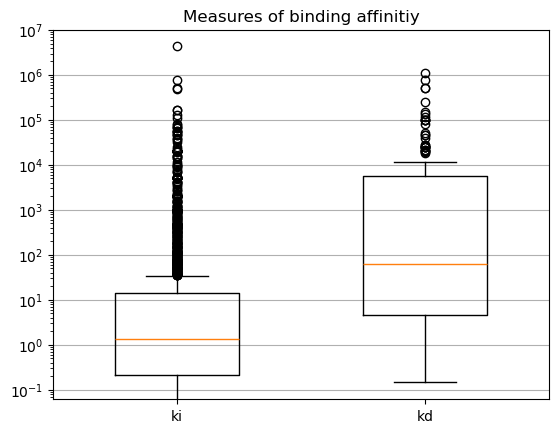

In [71]:
for i, col in enumerate(affinity_cols):
    plt.boxplot(filtered_df[col].dropna(), positions = [i], widths=0.5)
plt.title("Measures of binding affinitiy")
plt.xticks(range(len(affinity_cols)), affinity_cols)
plt.yscale('log')
plt.grid(axis="y")
plt.show()

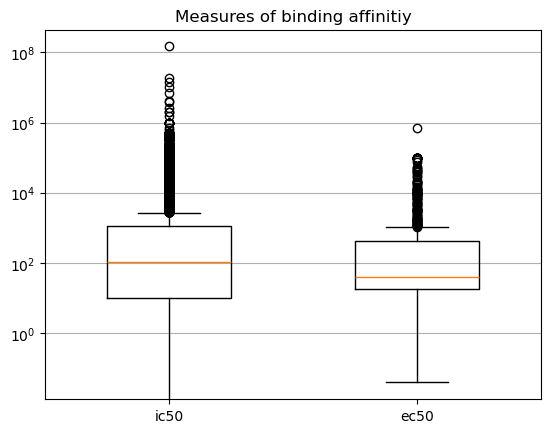

In [72]:
for i, col in enumerate(ec_ic):
    plt.boxplot(filtered_df[col].dropna(), positions = [i], widths=0.5)
plt.title("Measures of binding affinitiy")
plt.xticks(range(len(ec_ic)), ec_ic)
plt.yscale('log')
plt.grid(axis="y")
plt.show()

Text(0.5, 1.0, 'Histogram of NaN percentages for columns')

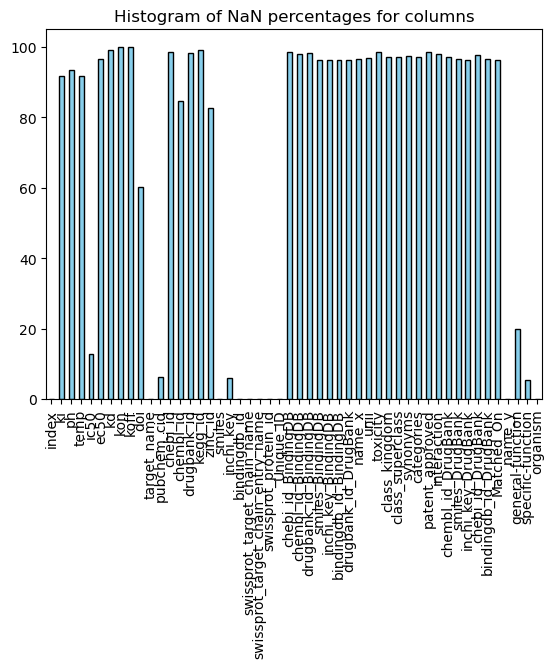

In [73]:
nan_counts_per_col = filtered_df.isna().mean(axis=0)*100
nan_counts_per_col.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Histogram of NaN percentages for columns")

### chemical context

Text(0, 0.5, 'counts')

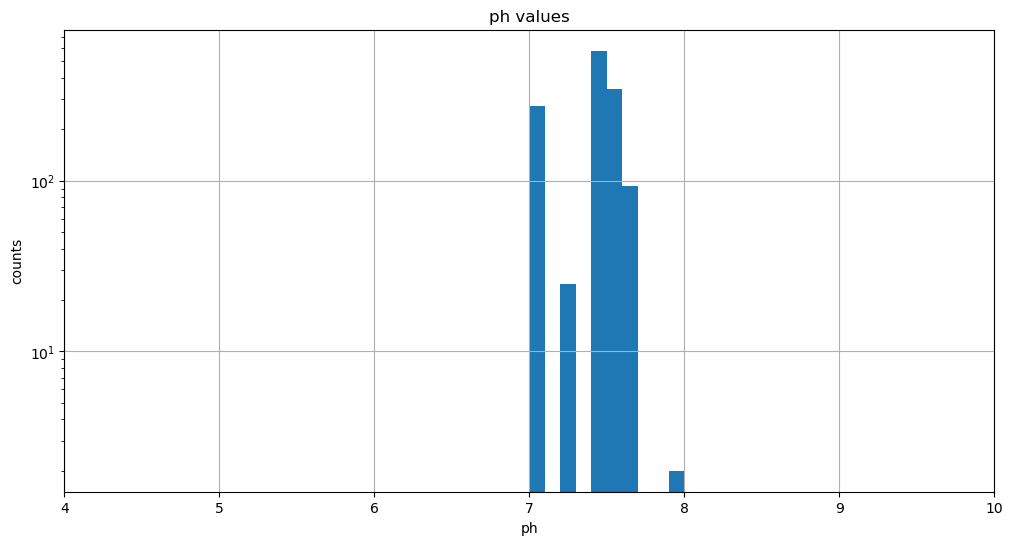

In [74]:
plt.figure(figsize=(12, 6)) 
filtered_df['ph'].hist(bins = 10)
plt.xticks(np.arange(15))
plt.title("ph values")
plt.xlabel("ph")
plt.yscale("log")
plt.xlim([4,10])
plt.ylabel("counts")

Text(0, 0.5, 'counts')

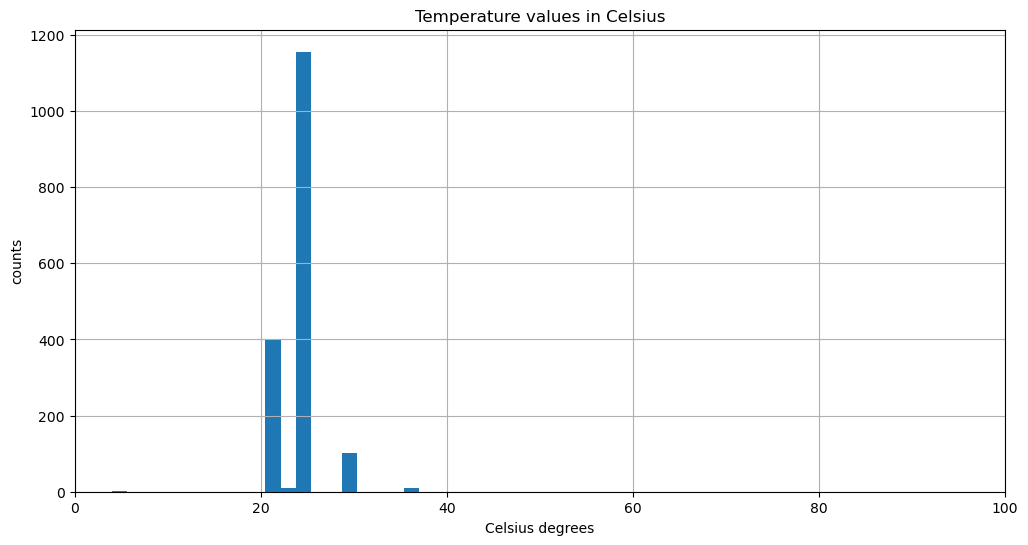

In [75]:
plt.figure(figsize=(12, 6)) 
filtered_df['temp'].hist(bins = 20)
plt.title("Temperature values in Celsius")
plt.xlim([0, 100])
plt.xlabel("Celsius degrees")
plt.ylabel("counts")

### Correlations
- Correlation between metrics of biding affinity, dosage, etc
- Possibly trying to see some groupings of data points (similarity in structure, metrics, types of disease being fought, ...)

In [76]:
chemical_par = ["ki", "ec50", "ic50", "kd", "ph", "temp"]
chemical_par_df = filtered_df[chemical_par].dropna(how='all')
chemical_par_df.head()

,ki,ec50,ic50,kd,ph,temp
0,<NA>,<NA>,840.0,<NA>,7.6,22.0
1,<NA>,<NA>,490.0,<NA>,7.6,22.0
2,<NA>,<NA>,640.0,<NA>,7.6,22.0
3,<NA>,<NA>,1900.0,<NA>,7.6,22.0
4,<NA>,<NA>,2800.0,<NA>,7.6,22.0


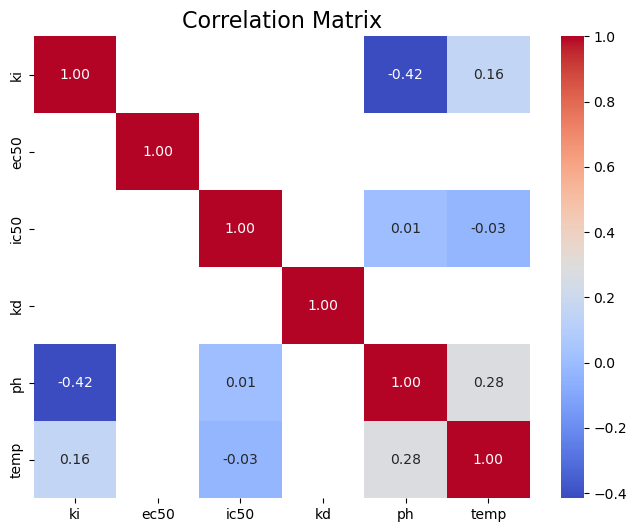

In [77]:
# Compute the correlation matrix
correlation_matrix = chemical_par_df.corr()

# Plot the heatmap using Seaborn
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)

# Add title and labels
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [78]:
print(diagnostic.kstest_normal(chemical_par_df["ki"].dropna().values, dist = 'norm'))
print(diagnostic.kstest_normal(chemical_par_df["ki"].dropna().values, dist = 'exp'))
print(diagnostic.kstest_normal(chemical_par_df["ic50"].dropna().values, dist = 'norm'))
print(diagnostic.kstest_normal(chemical_par_df["ic50"].dropna().values, dist = 'exp'))
print(diagnostic.kstest_normal(chemical_par_df["kd"].dropna().values, dist = 'norm'))
print(diagnostic.kstest_normal(chemical_par_df["kd"].dropna().values, dist = 'exp'))

(0.4818459653714887, 0.0009999999999998899)
(0.8477700628159955, 0.0009999999999998899)
(0.49339140312191404, 0.0009999999999998899)
(0.6950673567161945, 0.0009999999999998899)
(0.41405218662010035, 0.0009999999999998899)
(0.6311503387425389, 0.0009999999999998899)


In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regression model
model = LinearRegression()

# Iterate through pairs of columns
for i, col_i in enumerate(chemical_par):
    if i == len(chemical_par)-1:
        break
    for j, col_j in enumerate(chemical_par):
        if j == len(chemical_par)-1:
            break
        if (j != i) :
            # Filter rows where both columns are not NaN
            mask = chemical_par_df.iloc[:, i].notna() & chemical_par_df.iloc[:, j].notna()
            filtered_chemical_df = chemical_par_df[mask]
            if filtered_df.shape[0] != 0:
                print(f"NaN values left:\n{filtered_chemical_df.isna().sum()}")
                print(f"Size of the filtered df: {filtered_chemical_df.shape}")

                # Reshape data for the model (required for single feature models)
                X = np.log(filtered_chemical_df.iloc[:, i].to_numpy().reshape(-1, 1))  # Ensure X is 2D for sklearn
                y = np.log(filtered_chemical_df.iloc[:, j].values)  # y is already 1D, no need for reshape

                # Create a DataFrame for plotting with Seaborn
                data = pd.DataFrame({
                    "X": X.flatten(),  # Use .flatten() after converting X to a NumPy array
                    "y": y
                })

                # Train the model
                model.fit(X, y)

                # Make predictions
                y_pred = model.predict(X)

                # Evaluate the model
                mse = mean_squared_error(y, y_pred)
                r2 = r2_score(y, y_pred)

                print(f"Mean Squared Error: {mse}")
                print(f"R-squared: {r2}")

                # Display the coefficients
                coefficients = pd.DataFrame({
                    "Feature": [filtered_chemical_df.columns[i]],
                    "Coefficient": model.coef_
                })

                print("\nCoefficients:")
                print(coefficients)

                # Create a regression plot using Seaborn
                plt.figure(figsize=(8, 8))
                sns.regplot(x='X', y='y', data=data, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

                # Optional: Apply logarithmic scale to axes if data spans multiple orders of magnitude
                #plt.xscale("log")
                #plt.yscale("log")

                # Add labels and title dynamically
                plt.xlabel(filtered_chemical_df.columns[i])
                plt.ylabel(filtered_chemical_df.columns[j])
                plt.title(f"Linear Regression: {filtered_chemical_df.columns[j]} vs. {filtered_chemical_df.columns[i]}")

                # Show the plot
                plt.show()


NaN values left:
ki      0
ec50    0
ic50    0
kd      0
ph      0
temp    0
dtype: int64
Size of the filtered df: (0, 6)


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [85]:
mask = chemical_par_df.iloc[:, 0].notna()
filtered_chemical_df = chemical_par_df[mask]
filtered_chemical_df

,ki,ec50,ic50,kd,ph,temp
912,16000.0,<NA>,<NA>,<NA>,<NA>,30.0
913,20000.0,<NA>,<NA>,<NA>,<NA>,30.0
914,20000.0,<NA>,<NA>,<NA>,<NA>,30.0
915,2600.0,<NA>,<NA>,<NA>,<NA>,30.0
916,20000.0,<NA>,<NA>,<NA>,<NA>,30.0
...,...,...,...,...,...,...
19688,0.27,<NA>,<NA>,<NA>,<NA>,<NA>
19689,0.37,<NA>,<NA>,<NA>,<NA>,<NA>
19690,0.31,<NA>,<NA>,<NA>,<NA>,<NA>
19884,30.0,<NA>,<NA>,<NA>,<NA>,<NA>


In [111]:
counts = filtered_chemical_df.apply(pd.Series.value_counts)
counts["temp"].unique()


<IntegerArray>
[<NA>, 2, 48]
Length: 3, dtype: Int64

Text(0, 0.5, 'counts')

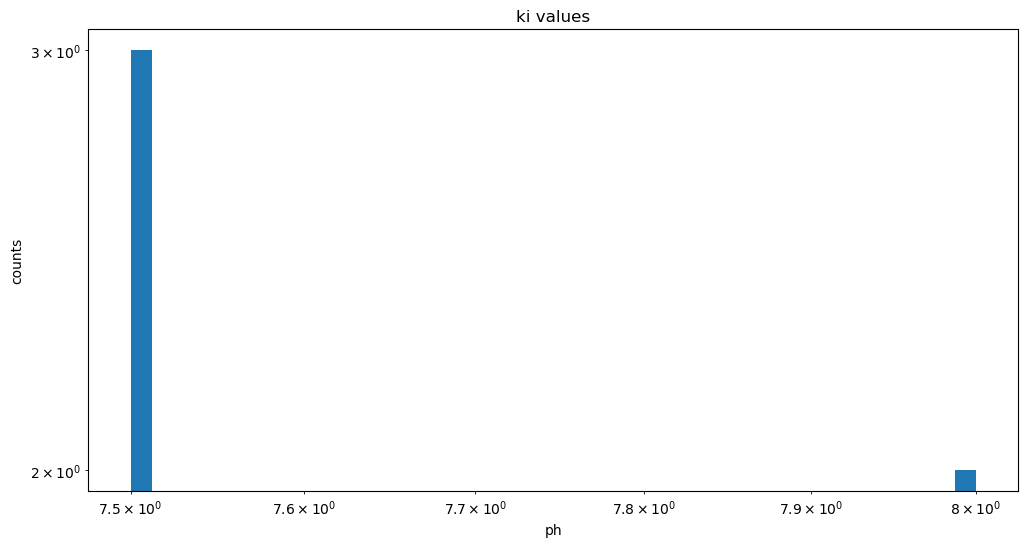

In [116]:
plt.figure(figsize=(12,6))
filtered_chemical_df["ph"].hist(bins = 40)
plt.xticks(np.arange(15))
plt.title("ki values")
plt.xlabel("ph")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("counts")